<a href="https://colab.research.google.com/github/rizqyjoe/Facial_Expression_Recognition_CNN_VGG16/blob/main/Coba1/Model%204_Scratch/1_Overfit_60%25ValAcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import keras
from keras.models import Sequential
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator

import zipfile 

import cv2
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

Load Data

In [3]:
path = '/content/drive/MyDrive/Dataset/fer2013 dataset/'
os.listdir(path)

['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv',
 'dataset',
 '.ipynb_checkpoints',
 'fer2013']

In [4]:
data = pd.read_csv(path+'icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']      
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [8]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Helping functions

In [9]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

Prepare the data

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [11]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [12]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


Display Sample of Images

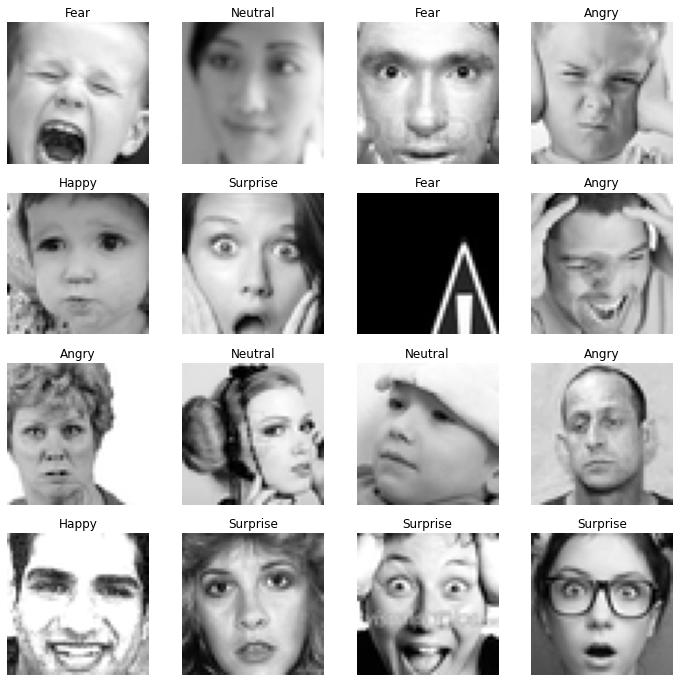

In [13]:
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()

Model

In [14]:
'''cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(7, activation='softmax'))

cnn.summary()

SyntaxError: ignored

In [15]:
%%time 

cnn = Sequential()

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(2048, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Dense(7, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 512)       1

In [ ]:
'''from keras.applications.vgg16 import VGG16

In [ ]:
'''cnn = Sequential()

cnn.add(VGG16(include_top = False,
              pooling='avg',
              weights='imagenet',
              input_shape=(48,48,3)))

cnn.add(Flatten())
cnn.add(Dropout(0.25))
cnn.add(Dense(2048, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dense(7, activation='softmax', name = 'classifer'))

cnn.summary()

In [16]:
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

Training 

In [17]:
h1 = cnn.fit(train_images, 
               train_labels, 
               batch_size=256, 
               epochs=30, 
               verbose=1, 
               validation_data = (valid_images, valid_labels)) 

Epoch 1/30
90/90 [==============================] - 91s 402ms/step - loss: 2.3999 - accuracy: 0.1733 - val_loss: 5.4803 - val_accuracy: 0.1466
Epoch 2/30
90/90 [==============================] - 26s 290ms/step - loss: 2.0103 - accuracy: 0.2241 - val_loss: 1.9177 - val_accuracy: 0.2168
Epoch 3/30
90/90 [==============================] - 26s 294ms/step - loss: 1.9208 - accuracy: 0.2312 - val_loss: 3.1005 - val_accuracy: 0.1263
Epoch 4/30
90/90 [==============================] - 27s 296ms/step - loss: 1.8499 - accuracy: 0.2584 - val_loss: 2.6023 - val_accuracy: 0.1635
Epoch 5/30
90/90 [==============================] - 27s 295ms/step - loss: 1.7614 - accuracy: 0.2976 - val_loss: 3.5258 - val_accuracy: 0.1635
Epoch 6/30
90/90 [==============================] - 27s 296ms/step - loss: 1.6223 - accuracy: 0.3690 - val_loss: 2.4180 - val_accuracy: 0.1672
Epoch 7/30
90/90 [==============================] - 27s 296ms/step - loss: 1.4765 - accuracy: 0.4275 - val_loss: 2.3265 - val_accuracy: 0.3704

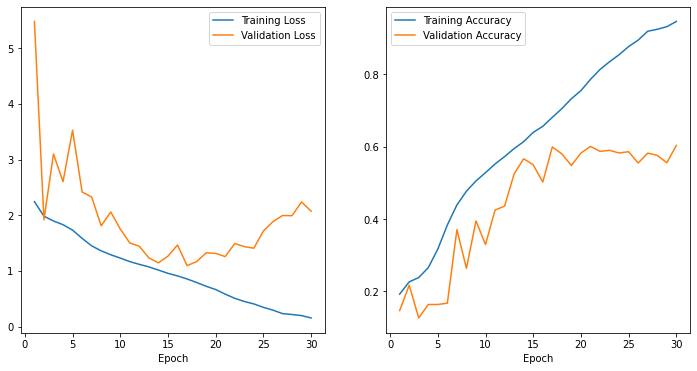

In [18]:
vis_training([h1])

Save Model

In [ ]:
cnn.save('final_model.h5')

Evaluating the model

In [19]:
test_prob = cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_labels)

print(test_accuracy)

0.5929228197269434


Confusion matrix

In [ ]:
conf_mat = confusion_matrix(test_labels, test_pred)

pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

Classification report

In [20]:
print(classification_report(test_labels, test_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.45      0.58      0.51       958
     Disgust       0.74      0.43      0.55       111
        Fear       0.51      0.31      0.39      1024
       Happy       0.81      0.79      0.80      1774
         Sad       0.45      0.54      0.49      1247
    Surprise       0.77      0.73      0.75       831
     Neutral       0.52      0.53      0.52      1233

    accuracy                           0.59      7178
   macro avg       0.61      0.56      0.57      7178
weighted avg       0.60      0.59      0.59      7178

